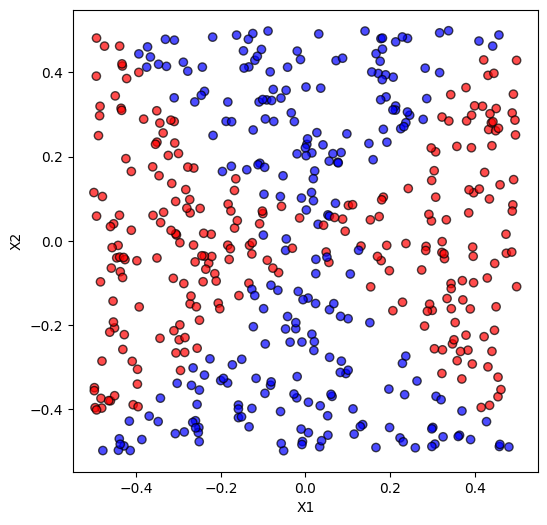

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rng = np.random.default_rng(5)
x1 = rng.uniform(size =500) - 0.5
x2 = rng.uniform(size =500) - 0.5
epsilon = rng.normal(size=500, scale=0.01)
y = x1**2 - x2**2 + epsilon > 0

df = pd.DataFrame({
    'Y': y,
    'X1': x1,
    'X2': x2
})

plt.figure(figsize=(6, 6))
plt.scatter(x1, x2, c=y, cmap="bwr", alpha=0.7, edgecolor="k")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [23]:
import statsmodels.api as sm
from ISLP.models import ModelSpec as MS 

X = MS(["X1", "X2"]).fit_transform(df)

glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      497
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -346.07
Date:                Thu, 04 Sep 2025   Deviance:                       692.14
Time:                        13:23:43   Pearson chi2:                     500.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001876
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0223      0.090      0.249      0.804      -0.153       0.198
X1            -0.1983      0.308     -0.644      0.519      -0.802       0.405
X2             0.2311      0.307      0.754      0.451      -0.370       0.832
==============================================================================
"""

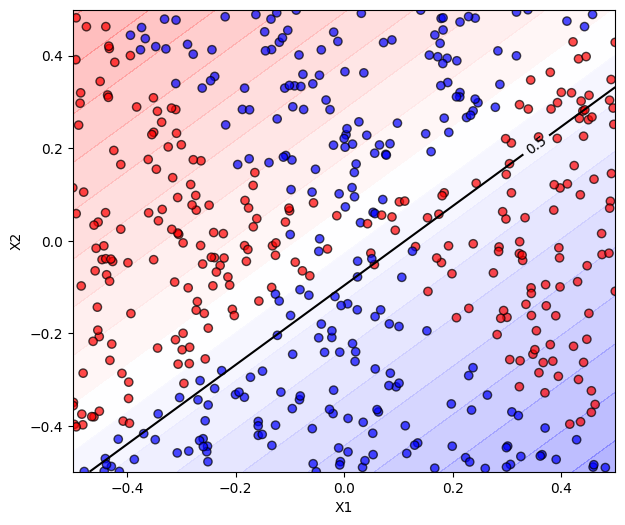

In [24]:
x1_range = np.linspace(df["X1"].min(), df["X1"].max(), 200)
x2_range = np.linspace(df["X2"].min(), df["X2"].max(), 200)
xx1, xx2 = np.meshgrid(x1_range, x2_range)

grid = pd.DataFrame({
    "X1": xx1.ravel(),
    "X2": xx2.ravel()
})

X_grid = MS(["X1", "X2"]).fit_transform(grid)
probs = results.predict(X_grid).values.reshape(xx1.shape)

plt.figure(figsize=(7, 6))
contour = plt.contour(xx1, xx2, probs, levels=[0.5], colors="black")
plt.clabel(contour, inline=True)
plt.contourf(xx1, xx2, probs, levels=20, cmap="bwr", alpha=0.3)
plt.scatter(df["X1"], df["X2"], c=y, cmap="bwr", edgecolor="k", alpha=0.7)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

The logistic regression model performed very poorly on this dataset. None of the predictors are statistically significant, as shown by their large p-values, and the pseudo R² is essentially zero, indicating that the model explains almost none of the variation in the outcome. This failure is expected because the true decision boundary is quadratic ($X1^2 - X2^2 > 0$), while the fitted model only includes linear terms in $X1$ and $X2$. As a result, the fitted decision surface is a straight line, which cannot capture the underlying nonlinear class separation, leading to near-random predictive performance.

In [25]:
from ISLP.models import poly

X = MS([poly("X1", degree=2), poly("X2", degree=2), ("X1", "X2")]).fit_transform(df)

glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      494
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.531
Date:                Thu, 04 Sep 2025   Deviance:                       73.062
Time:                        13:23:43   Pearson chi2:                     102.
No. Iterations:                    11   Pseudo R-squ. (CS):             0.7106
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 0.6236      0.384      1.624      0.104      -0.129       1.376
poly(X1, degree=2)[0]   -23.0411     10.282     -2.241      0.025     -43.193      -2.889
poly(X1, degree=2)[1]   416.6050     82.075      5.076      0.000     255.742     577.468
poly(X2, degree=2)[0]    39.4200     12.105      3.256      0.001      15.695      63.145
poly(X2, degree=2)[1]  -397.8220     77.771     -5.115      0.000    -550.251    -245.393
X1:X2                     0.9858      3.680      0.268      0.789      -6.228       8.199
=========================================================================================
"""

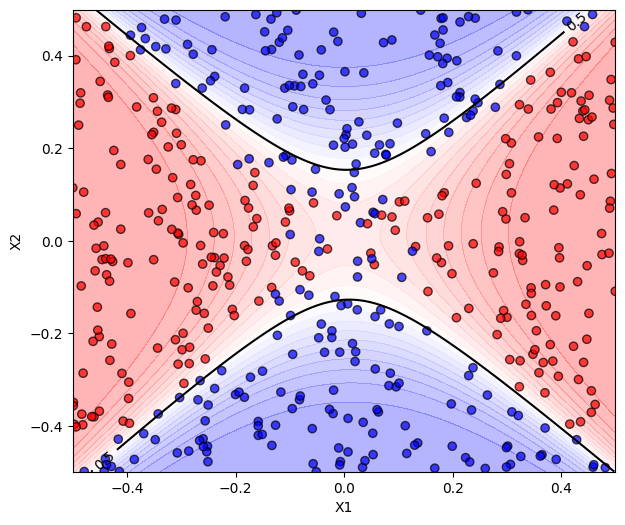

In [26]:
X_grid = MS([poly("X1", degree=2), poly("X2", degree=2), ("X1", "X2")]).fit_transform(grid)
probs = results.predict(X_grid).values.reshape(xx1.shape)

plt.figure(figsize=(7, 6))
contour = plt.contour(xx1, xx2, probs, levels=[0.5], colors="black")
plt.clabel(contour, inline=True)
plt.contourf(xx1, xx2, probs, levels=20, cmap="bwr", alpha=0.3)
plt.scatter(df["X1"], df["X2"], c=y, cmap="bwr", edgecolor="k", alpha=0.7)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

The GLM, which included second-degree polynomial terms for **X1** and **X2**, successfully captured the true quadratic trend in the data. The significant coefficients for both **X1²** and **X2²** (with opposite signs) align perfectly with the underlying data-generating process, $y = x_1^2 - x_2^2 + \epsilon > 0$, showing that the model correctly identified the saddle-shaped decision boundary. The high Pseudo R-squared (\~0.71) further confirms that the model explains most of the variation in the binary outcome, and the scatter plot shows that the predicted separation aligns with the curvature of the points.

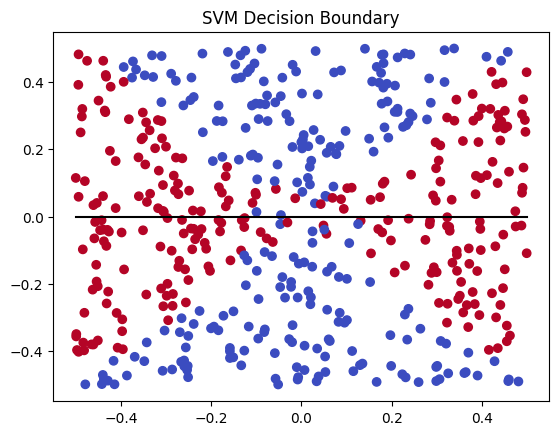

In [28]:
from sklearn.svm import SVC

svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)

w = svm_linear.coef_[0]
b = svm_linear.intercept_[0]

X = np.array(df[['X1', 'X2']])
y = np.array(df['Y'])

x_plot = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_plot = -(w[0]*x_plot + b)/w[1]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.plot(x_plot, y_plot, 'k-')
plt.title('SVM Decision Boundary')
plt.show()

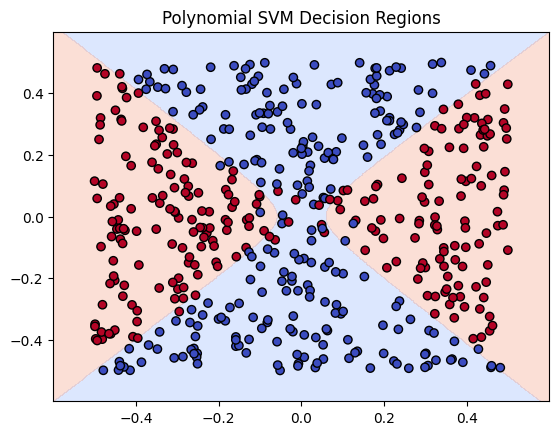

In [ ]:
x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

svm_p = SVC(kernel='poly', degree=2)
svm_p.fit(X, y)

Z = svm_p.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title('Polynomial SVM Decision Regions')
plt.show()

The comparison between the two SVM models clearly illustrates the importance of matching the model complexity to the underlying data structure. The linear SVM drastically underperformed because it attempts to separate the classes with a straight line, which cannot capture the curved, saddle-shaped boundary inherent in the data generated by $y = x_1^2 - x_2^2 + \epsilon > 0$. As a result, the linear decision boundary misclassifies a large number of points and fails to align with the true separation of the classes. In contrast, the polynomial SVM with degree 2 successfully models the quadratic relationship, producing a curved decision region that accurately separates the positive and negative classes. The contour plot shows how the polynomial SVM follows the natural curvature of the data, demonstrating far superior performance and visually confirming that incorporating the correct nonlinearity is crucial for this problem.